# This notebook contains:
* Function to get filepaths for temperature and specific humidity at different pressure levels
* Function to combine temp/humidity into one dataset across the vertical profile
* Function to calculate equivalent potential temperature (theta-e) from temp/specific humidity
* Function to calculate mean hourly theta-e for different wind regimes and plot
* Function to calculate overall mean vertical profiles of theta-e and plot
* Plots

In [4]:
# import libraries
import xarray as xr
import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import griddata
from datetime import datetime
import pandas as pd
import dask
from metpy.constants import Rd, g
from metpy.xarray import preprocess_and_wrap
import dask as da

# Functions to calculate equivalent potential temperature

In [25]:
def list_variable_file_paths(variable: str) -> list[str]:
    """Function to return a list of file paths (str) of BARRA-2 netcdf4 variable files

    Args:
        variable (str): The BoM variable name. The BARRA-2 list of variable names can be found at http://www.bom.gov.au/research/publications/researchreports/BRR-067.pdf (Chun-Hsu Su et al., 2022).  e.g. ta200 (temperature at 200 hPa) and hus950 (specific humidity at 950 hPa)

    Returns:
        list[str]: File paths to variable
    """
    # This list of month strings is used to only look at data for time periods with associated radar data (2012-2022)
    list = ["202201-202201","202202-202202","202101-202101","202102-202102","202103-202103","202104-202104","202001-202001","202002-202002",
           "202003-202003","202004-202004","201901-201901","201902-201902","201903-201903","201904-201904","201801-201801","201802-201802",
           "201803-201803","201804-201804","201701-201701","201702-201702","201703-201703","201704-201704","201601-201601","201602-201602",
           "201603-201603","201604-201604","201501-201501","201502-201502","201503-201503","201504-201504","201401-201401","201402-201402",
           "201403-201403","201404-201404","201301-201301","201302-201302","201303-201303","201304-201304","201201-201201","201202-201202",
           "201203-201203","201204-201204"]
    list.sort()
    file_paths = []
    for i in list:
        fp = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+variable+"/v20240516/" # the version name periodicly updates
        all_files = [fp+variable+"_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_"+i+".nc"]
        file_paths.extend(all_files)
    file_paths.sort()
    return file_paths  


def open_and_combine_variable(file_paths: list[str],variable_sel1: int,variable_sel2: int) -> {xr.Dataset,xr.Dataset,xr.Dataset}:
    """Function to open netcdf4 files for a BARRA-2 variable, select a single lat-lon point, and combine values along every pressure level into a single dataset for Townsville, Cairns and Willis Island locations.

    Args:
        file_paths (list[str]): File paths generated from: list_variable_file_paths function
        variable_sel1 (int): Extract the BoM BARRA-2 variable string from the file path e.g. for temp, =102, hus =103
        variable_sel2 (int): Extract the BoM BARRA-2 variable string from the file path e.g. for temp, =107, hus = 109

    Returns:
        xr.Dataset,xr.Dataset,xr.Dataset: {Townsville, Cairns, Willis Island} BARRA-2 dataset for a variable over every pressure level
    """
    datasets_towns=[]
    datasets_cairns=[]
    datasets_willis=[]
    for fp in file_paths:
        with xr.open_mfdataset(fp, engine="h5netcdf", chunks="auto") as ds:
            # select coordinates closest to radar sites & drop the pressure variable (conflicting)
            towns = ds.sel(lat=-19.4198,lon=146.5509,method="nearest").drop_vars('pressure')
            cairns = ds.sel(lat=-16.817,lon=145.683,method="nearest").drop_vars('pressure')
            willis = ds.sel(lat=-16.2874,lon=149.9646,method="nearest").drop_vars('pressure')

            # Extract variable name in filepath string
            towns = towns[fp[0][variable_sel1:variable_sel2]]
            cairns = cairns[fp[0][variable_sel1:variable_sel2]]
            willis = willis[fp[0][variable_sel1:variable_sel2]]
            
            datasets_towns.append(towns)
            datasets_cairns.append(cairns)
            datasets_willis.append(willis)
            ds.close()

    # combine result for each pressure level into one array
    combine_towns = xr.combine_by_coords(datasets_towns)
    combine_cairns = xr.combine_by_coords(datasets_cairns)
    combine_willis = xr.combine_by_coords(datasets_willis)
    return combine_towns,combine_cairns,combine_willis


def calc_eqpt(p: np.array, t: np.array, q: np.array) -> np.ndarray:
    """Calculates equivalent potential temperature in [K] from pressure [Pa], temperature [K] and specific humidity [kg/kg].

    Args:
        p (np.array): pressure in [Pa]
        t (np.array): temperature in [K]
        q (np.array): specific humidity in [kg/kg]
    p, t and q can be scalars or np arrays.

    Returns: 
        Equivalent potential temperature in [K].
    """
    return mpcalc.equivalent_potential_temperature(units.Pa * p, units.K * t,mpcalc.dewpoint_from_specific_humidity(units.Pa * p, units.K * t, q)).to("K").m


def calculate_single_hour_mean(hour: int, wind_dir: xr.DataArray, ds: xr.Dataset):
    """A delayed function for the calculation of a single hour (between 0-24) for mean values of temperature and specific humidity.
    Args:
        hour (int): Integer between 0-24
        wind_dir (xr.DataArray): Wind direction (degrees) 
        ds (xr.Dataset): Dataset produced by: open_and_combine_variable

    Returns:
        da.delayed: A delayed array of mean (over time) values
    """
    wind_times_hour = wind_dir.groupby(wind_dir.time.dt.hour == hour)
    wind_result = wind_times_hour[1].time.values
    ds_regime = ds.sel(time=wind_result)
    mean_values_lazy = da.delayed(ds_regime.drop_vars(["lon", "lat"]).mean(dim='time'))
    return mean_values_lazy


def variable_hourly_mean_values(barra_ds: xr.Dataset,deg1: int,deg2: int,barra_variable_ds: xr.Dataset,ne: bool=False,all_winds: bool=False) -> np.ndarray:
    """Function to compute hourly mean values of temperature and specific humidity (which can then be used to calculate av. hourly mean eqpt). 

    Args:
        barra_ds (xr.Dataset): The wind regime dataset to apply (Townsville, Cairns or Willis Island)
        deg1 (int): Wind direction in degrees start of slice
        deg2 (int): Wind direction in degrees end of slice
        barra_variable_ds (xr.Dataset): Which BARRA-2 variable dataset to calculate mean values of i.e. temperature or specific humidity e.g. ta_towns
        ne (bool, optional): If True wind direction start slice >=0 degrees. Defaults to False.
        all_winds (bool, optional): If True all time periods are analysed (climatological means). Defaults to False.

    Returns:
        np.ndarray: Array of hourly mean values for a given BARRA-2 variable
    """
    winds = barra_ds.wind_dir.compute()
    if ne:
        winds_dir = winds[(winds>=deg1)&(winds<=deg2)]
    else:
        winds_dir = winds[(winds>deg1)&(winds<=deg2)]
    if all_winds:
        winds_dir = winds
    else:
        pass
    mean_values = []
    # use defined function to calc mean
    for hour in np.arange(0, 24, 1):
        mean_values.append(calculate_single_hour_mean(hour, winds_dir, barra_variable_ds)) 
    return da.compute(mean_values, scheduler='processes')[0]


def extract_mean_values(mean_result: np.ndarray) -> np.ndarray:
    """Function to create hourly mean values and return as an array.

    Args:
        mean_result (np.ndarray): Results from function: variable_hourly_mean_values

    Returns:
        np.ndarray: Mean values in UTC
    """
    values_UTC = []
    for hour in np.arange(0,24,1):
        mean_values_array = mean_result[hour]
        var_names = list(mean_values_array.data_vars.keys())
        result = [mean_values_array[var].values for var in reversed(var_names)]
        values_UTC.append(result)
    return values_UTC

# Plotting functions

In [73]:
def plot_eqpt_mean_anomalies(site: dict, title: str) -> None:
    """Function to plot mean and anomaly profiles of eqpt

    Args:
        site (dict): Dictionary of eqpt for climatological and regime values at each pressure level and hour
        title (str): Site name
    """
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(1,2, figsize=[12,6])
    pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
    
    #plot mean
    ax[0].plot(site['eqpt'].mean(axis=0),pressure,label="Mean",color="black",linestyle='--',linewidth=2)
    ax[0].plot(site['eqptNE'].mean(axis=0),pressure,label="NE",color="seagreen",linewidth=2)
    ax[0].plot(site['eqptSE'].mean(axis=0),pressure,label="SE",color="royalblue",linewidth=2)
    ax[0].plot(site['eqptSW'].mean(axis=0),pressure,label="SW",color="purple",linewidth=2)
    ax[0].plot(site['eqptNW'].mean(axis=0),pressure,label="NW",color="orange",linewidth=2)

    # plot anomalies
    ax[1].plot(site['eqptNE'].mean(axis=0)-site['eqpt'].mean(axis=0),pressure,label="NE",color="seagreen",linewidth=2)
    ax[1].plot(site['eqptSE'].mean(axis=0)-site['eqpt'].mean(axis=0),pressure,label="SE",color="royalblue",linewidth=2)
    ax[1].plot(site['eqptSW'].mean(axis=0)-site['eqpt'].mean(axis=0),pressure,label="SW",color="purple",linewidth=2)
    ax[1].plot(site['eqptNW'].mean(axis=0)-site['eqpt'].mean(axis=0),pressure,label="NW",color="orange",linewidth=2)

    # plot dashed line for climatological average
    ax[1].plot([0]*(len(pressure)),pressure,color="black",linestyle="--",linewidth=2)

    # Other
    ax[0].legend()
    ax[1].legend(loc="upper left")
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    plt.xlim(-9,9)
    yticklabels = ["200","300","400","500","600","700","800","900"]
    ax[0].set_yticks(np.arange(20000,100000,10000),yticklabels)
    ax[1].set_yticks(np.arange(20000,100000,10000),yticklabels)
    ax[0].set_ylabel("Pressure (hPa)")
    ax[0].set_xlabel("θ\u2091 (K)",fontsize=15)
    ax[1].set_xlabel("θ\u2091 wind regime - θ\u2091 clim  (K)",fontsize=15)
    ax[0].set_title("θ\u2091 mean",fontsize=20)
    ax[1].set_title("θ\u2091 anomaly",fontsize=20)
    fig.suptitle(title,fontsize=20)

In [74]:
def plot_hourly_eqpt(site: str,eqpt: np.ndarray,eqptNE: np.ndarray,eqptSE: np.ndarray,eqptSW: np.ndarray,eqptNW: np.ndarray,single_plot: bool=False) -> None:
    """Function to plot a 4-panel eqpt mean hourly regime plot, or a single panel plot showing the spread of climatological and regime eqpt.

    Args:
        site (str): Title string: Townsville, Cairns or Willis Island
        eqpt (np.ndarray): Array of hourly climatological eqpt
        eqptNE (np.ndarray): Array of hourly north-easterly eqpt
        eqptSE (np.ndarray): Array of hourly south-easterly eqpt
        eqptSW (np.ndarray): Array of hourly south-westerly eqpt
        eqptNW (np.ndarray): Array of hourly north-westerly eqpt
        single_plot (bool, optional): If True all hourly mean eqpt are plotted for each regime. Defaults to False (a 4-panel plot is then plotted for each regime).
    """
    yticklabels = ["200","300","400","500","600","700","800","900"]
    if single_plot==True:
        fig,ax = plt.subplots(1,1, figsize=[8,8])
        ax.invert_yaxis()
        for i in np.arange(0,23,1):
            ax.plot(eqpt[i],pressure,color="black",linestyle='--',linewidth=0.5)
            ax.plot(eqptNE[i],pressure,color="seagreen",linewidth=0.2)
            ax.plot(eqptNW[i],pressure,color="gold",linewidth=0.2)
            ax.plot(eqptSE[i],pressure,color="royalblue",linewidth=0.2)
            ax.plot(eqptSW[i],pressure,color="purple",linewidth=0.2)
        ax.plot(eqpt[23],pressure,label="Clim",color="black",linestyle='--',linewidth=0.5)
        ax.plot(eqptNE[23],pressure,label="NE",color="seagreen",linewidth=0.2)
        ax.plot(eqptSE[23],pressure,label="SE",color="royalblue",linewidth=0.2)
        ax.plot(eqptSW[23],pressure,label="SW",color="purple",linewidth=0.2)
        ax.plot(eqptNW[23],pressure,label="NW",color="gold",linewidth=0.2)
        plt.legend()
        ax.set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax.set_ylabel("Pressure (hPa)")
        ax.set_xlabel("θ\u2091 (K)")
        ax.grid()
        ax.set_xlim(331,357.5)
    else:
        fig,ax = plt.subplots(2,2, figsize=[8,8])
        ax[0,0].invert_yaxis()
        ax[0,1].invert_yaxis()
        ax[1,0].invert_yaxis()
        ax[1,1].invert_yaxis()
        # plot regimes as mean values or difference from mean climatological conditions
        levels = np.arange(330,359,2) #np.arange(-4,11,1) 
        eqpt_NET = eqptNE.T
        ax[0,1].contourf(np.arange(0,24,1),pressure,eqpt_NET,levels=levels,cmap="binary")
        eqpt_SET = eqptSE.T
        ax[1,1].contourf(np.arange(0,24,1),pressure,eqpt_SET,levels=levels,cmap="binary")
        eqpt_SWT = eqptSW.T
        ax[1,0].contourf(np.arange(0,24,1),pressure,eqpt_SWT,levels=levels,cmap="binary")
        eqpt_NWT = eqptNW.T
        ax[0,0].contourf(np.arange(0,24,1),pressure,eqpt_NWT,levels=levels,cmap="binary")
        cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        # Create a colorbar using the ScalarMappable from one of the subplots
        sm = plt.cm.ScalarMappable(cmap="binary")
        sm.set_array(levels)  
        cbar = plt.colorbar(sm,label='θ\u2091 (K)',cax=cax)
        ax[0,0].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[0,1].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[1,1].set_yticks(np.arange(20000,100000,10000),yticklabels)
        ax[1,0].set_yticks(np.arange(20000,100000,10000),yticklabels)
        
        ax[0,0].set_xticks(np.arange(0,24,6))
        ax[0,1].set_xticks(np.arange(0,24,6),)
        ax[1,1].set_xticks(np.arange(0,24,6),)
        ax[1,0].set_xticks(np.arange(0,24,6),)
        ax[0,0].set_title('NW')
        ax[0,1].set_title('NE')
        ax[1,1].set_title('SE')
        ax[1,0].set_title('SW')
        ax[0,0].set_ylabel("Pressure (hPa)")
        ax[1,0].set_ylabel("Pressure (hPa)")
        ax[1,0].set_xlabel("Hour (AEST)")
        ax[1,1].set_xlabel("Hour (AEST)")
    plt.suptitle(site+' Regimes: θ\u2091 Hourly Mean') 

# Results

In [26]:
# Create lists of file paths to each variable, then open and combine along pressure levels
ta950 = list_variable_file_paths("ta950") 
ta925 = list_variable_file_paths("ta925") 
ta850 = list_variable_file_paths("ta850") 
ta700 = list_variable_file_paths("ta700") 
ta600 = list_variable_file_paths("ta600") 
ta500 = list_variable_file_paths("ta500") 
ta400 = list_variable_file_paths("ta400")
ta300 = list_variable_file_paths("ta300") 
ta200 = list_variable_file_paths("ta200")
hus950 = list_variable_file_paths("hus950") 
hus925 = list_variable_file_paths("hus925") 
hus850 = list_variable_file_paths("hus850") 
hus700 = list_variable_file_paths("hus700") 
hus600 = list_variable_file_paths("hus600") 
hus500 = list_variable_file_paths("hus500") 
hus400 = list_variable_file_paths("hus400")
hus300 = list_variable_file_paths("hus300") 
hus200 = list_variable_file_paths("hus200")
ta_towns, ta_cairns, ta_willis = open_and_combine_variable([ta950,ta925,ta850,ta700,ta600,ta500,ta400,ta300,ta200],102,107)
spc_towns, spc_cairns, spc_willis = open_and_combine_variable([hus950,hus925,hus850,hus700,hus600,hus500,hus400,hus300,hus200],103,109)

In [28]:
# Open barra2 850hPa wind regime files to create composites
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

In [9]:
# run functions to get UTC (24,9) shaped arrays of mean variable values for each pressure level each hour
ta_newinds_UTC = variable_hourly_mean_values(barra_towns,0,90,ta_towns,ne=True,all_winds=False)
ta_ne_UTC = extract_mean_values(ta_newinds_UTC)
ta_nwwinds_UTC = variable_hourly_mean_values(barra_towns,270,360,ta_towns,ne=False,all_winds=False)
ta_nw_UTC = extract_mean_values(ta_nwwinds_UTC)
ta_sewinds_UTC = variable_hourly_mean_values(barra_towns,90,180,ta_towns,ne=False,all_winds=False)
ta_se_UTC = extract_mean_values(ta_sewinds_UTC)
ta_swwinds_UTC = variable_hourly_mean_values(barra_towns,180,270,ta_towns,ne=False,all_winds=False)
ta_sw_UTC = extract_mean_values(ta_swwinds_UTC)
ta_winds_UTC = variable_hourly_mean_values(barra_towns,270,360,ta_towns,ne=False,all_winds=True)
ta_UTC = extract_mean_values(ta_winds_UTC)
# same as above but for specific humidity
spc_newinds_UTC = variable_hourly_mean_values(barra_towns,0,90,spc_towns,ne=True,all_winds=False)
spc_ne_UTC = extract_mean_values(spc_newinds_UTC)
spc_sewinds_UTC = variable_hourly_mean_values(barra_towns,90,180,spc_towns,ne=False,all_winds=False)
spc_se_UTC = extract_mean_values(spc_sewinds_UTC)
spc_swwinds_UTC = variable_hourly_mean_values(barra_towns,180,270,spc_towns,ne=False,all_winds=False)
spc_sw_UTC = extract_mean_values(spc_swwinds_UTC)
spc_nwwinds_UTC = variable_hourly_mean_values(barra_towns,270,360,spc_towns,ne=False,all_winds=False)
spc_nw_UTC = extract_mean_values(spc_nwwinds_UTC)
spc_winds_UTC = variable_hourly_mean_values(barra_towns,270,360,spc_towns,ne=False,all_winds=True)
spc_UTC = extract_mean_values(spc_winds_UTC)

CPU times: user 3min 53s, sys: 17.5 s, total: 4min 10s
Wall time: 20min 36s


In [11]:
# Calculate eqpt
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
eqpt_NE = []
eqpt_SE = []
eqpt_SW = []
eqpt_NW = []
eqpt_clim = []
for hour in np.arange(0,24,1):
    eqpt_clim.append(calc_eqpt(pressure, np.array(ta_UTC[hour]), np.array(spc_UTC[hour])))
    eqpt_NE.append(calc_eqpt(pressure, np.array(ta_ne_UTC[hour]), np.array(spc_ne_UTC[hour])))
    eqpt_SE.append(calc_eqpt(pressure, np.array(ta_se_UTC[hour]), np.array(spc_se_UTC[hour])))
    eqpt_SW.append(calc_eqpt(pressure, np.array(ta_sw_UTC[hour]), np.array(spc_sw_UTC[hour])))
    eqpt_NW.append(calc_eqpt(pressure, np.array(ta_nw_UTC[hour]), np.array(spc_nw_UTC[hour])))

# Adjust to local time
eqpt_roll = np.roll(eqpt_clim,shift=10,axis=0)
eqpt_NE_roll = np.roll(eqpt_NE,shift=10,axis=0)
eqpt_SE_roll = np.roll(eqpt_SE,shift=10,axis=0)
eqpt_SW_roll = np.roll(eqpt_SW,shift=10,axis=0)
eqpt_NW_roll = np.roll(eqpt_NW,shift=10,axis=0)

# Save array
# np.save('/home/563/ac9768/barra-2/eqpt_NW_towns.npy', eqpt_NW_roll)

# Plot

In [50]:
# Load eqpt results into dictionaries for each site
towns_eqpt = {
    'eqpt': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_towns.npy'),
    'eqptNE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NE_towns.npy'),
    'eqptSE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SE_towns.npy'),
    'eqptSW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SW_towns.npy'),
    'eqptNW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NW_towns.npy')
}

cairns_eqpt = {
    'eqpt': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_cairns.npy'),
    'eqptNE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NE_cairns.npy'),
    'eqptSE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SE_cairns.npy'),
    'eqptSW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SW_cairns.npy'),
    'eqptNW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NW_cairns.npy')
}

willis_eqpt = {
    'eqpt': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_willis.npy'),
    'eqptNE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NE_willis.npy'),
    'eqptSE': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SE_willis.npy'),
    'eqptSW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_SW_willis.npy'),
    'eqptNW': np.load('/home/563/ac9768/barra-2/eqpt/eqpt_NW_willis.npy')
}

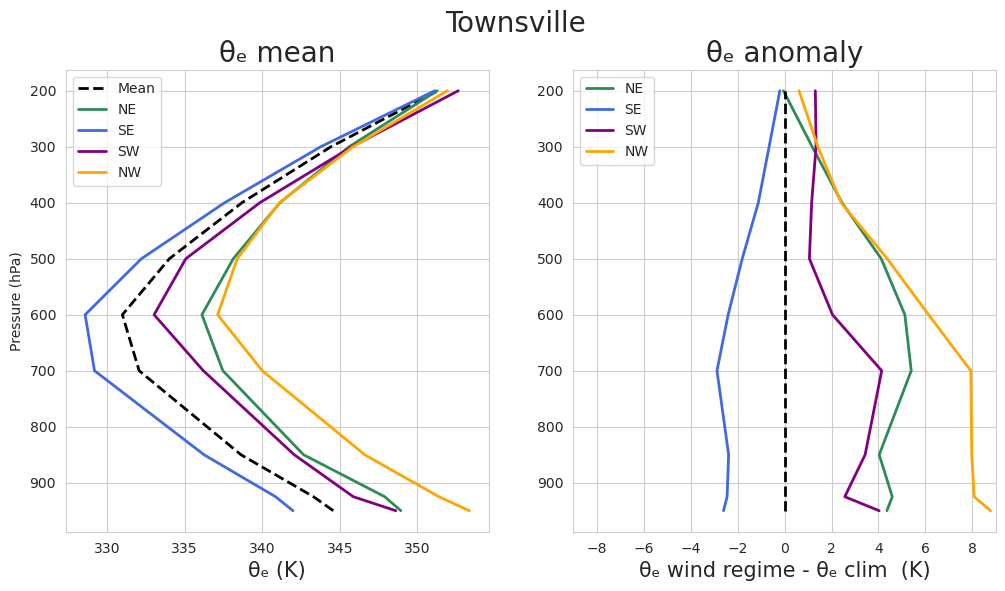

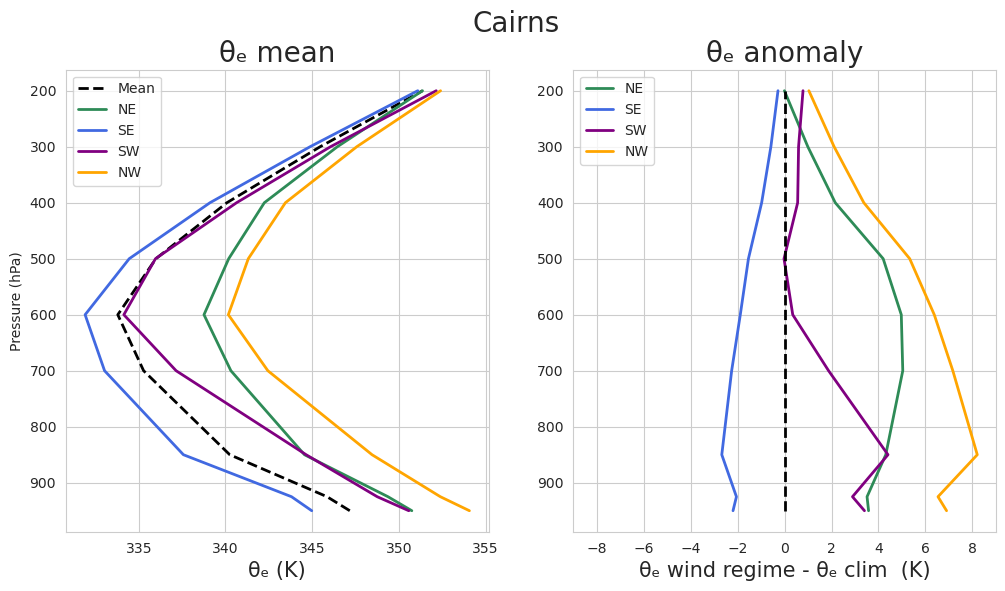

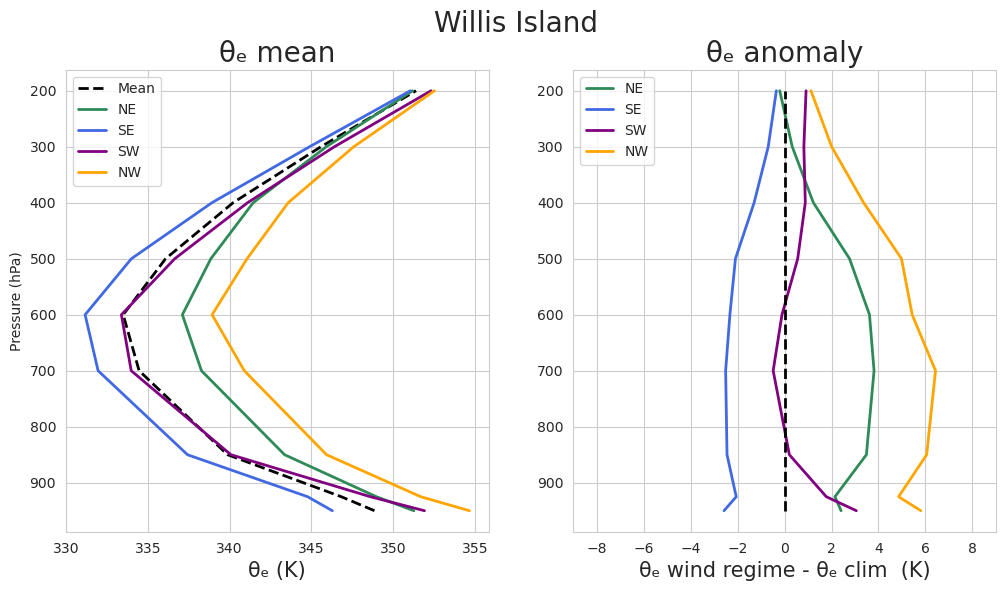

In [76]:
plot_eqpt_mean_anomalies(towns_eqpt,'Townsville')
plot_eqpt_mean_anomalies(cairns_eqpt,'Cairns')
plot_eqpt_mean_anomalies(willis_eqpt,'Willis Island')

Text(0.5, 0, 'Hour (LST)')

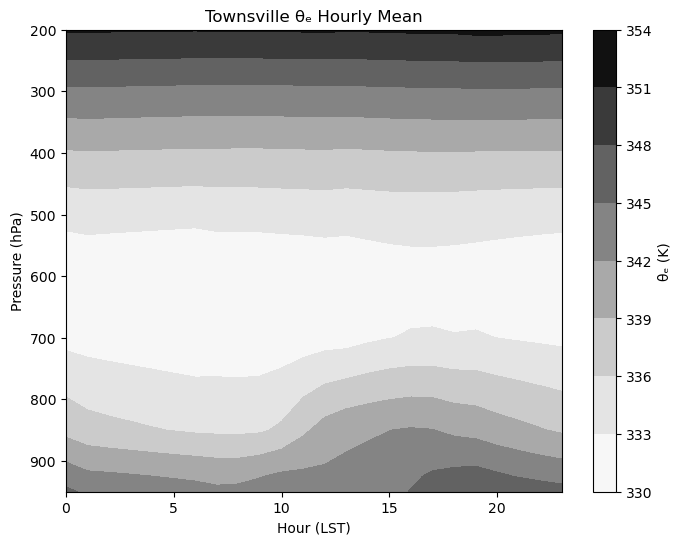

In [53]:
# Plot eqpt climatology
fig,ax = plt.subplots(1,1, figsize=[8,6])
pressure = np.array([95000,92500,85000,70000,60000,50000,40000,30000,20000])
ax.invert_yaxis()
eqptT = towns_eqpt['eqpt'].T
clim=ax.contourf(np.arange(0,24,1),pressure,eqptT,cmap="Greys")
plt.colorbar(clim,label='θ\u2091 (K)',ax=ax)
plt.title('Townsville θ\u2091 Hourly Mean')
yticklabels = ["200","300","400","500","600","700","800","900"]
ax.set_yticks(np.arange(20000,100000,10000),yticklabels)
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel('Hour (LST)')

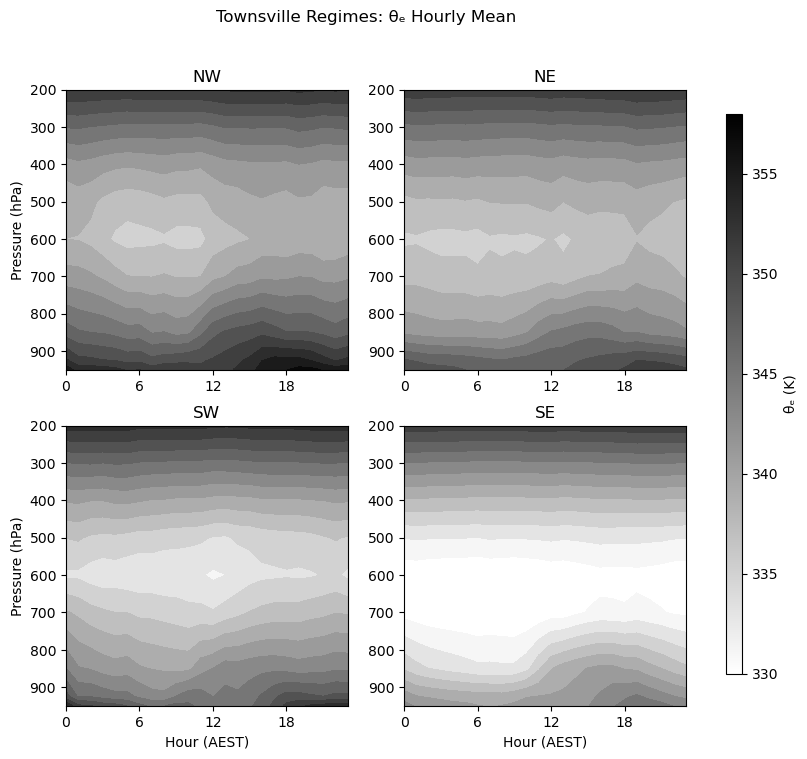

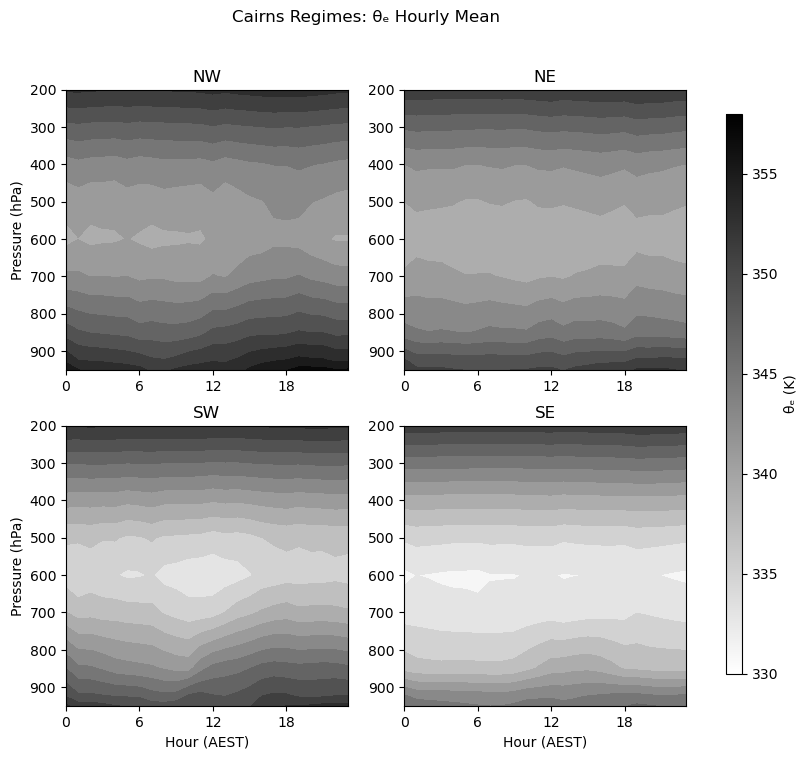

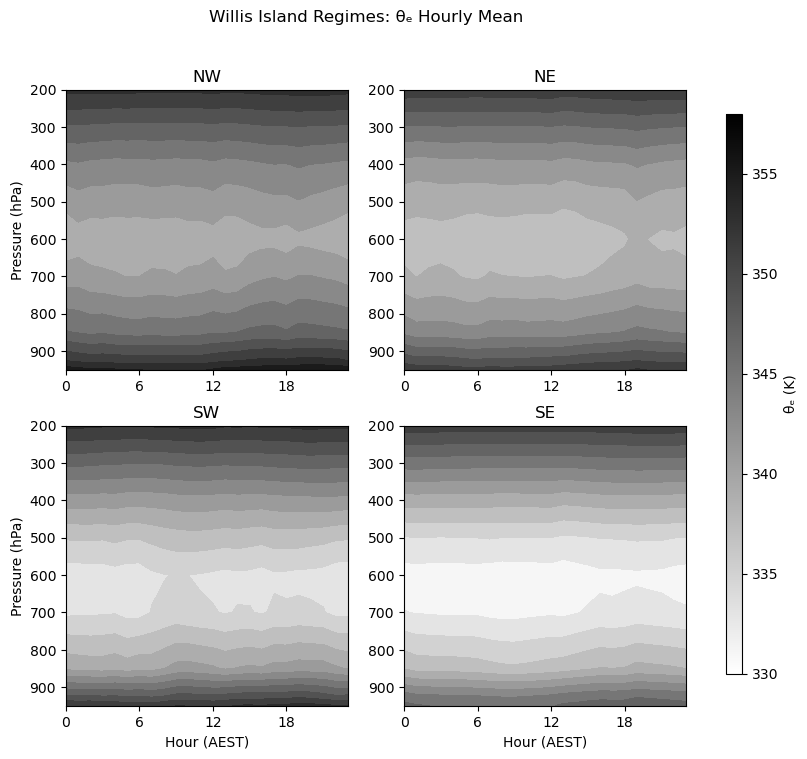

In [57]:
# Plot eqpt regimes
plot_hourly_eqpt("Townsville",towns_eqpt['eqpt'],towns_eqpt['eqptNE'],towns_eqpt['eqptSE'],towns_eqpt['eqptSW'],towns_eqpt['eqptNW'],single_plot=False)
plot_hourly_eqpt("Cairns",cairns_eqpt['eqpt'],cairns_eqpt['eqptNE'],cairns_eqpt['eqptSE'],cairns_eqpt['eqptSW'],cairns_eqpt['eqptNW'],single_plot=False)
plot_hourly_eqpt("Willis Island",willis_eqpt['eqpt'],willis_eqpt['eqptNE'],willis_eqpt['eqptSE'],willis_eqpt['eqptSW'],willis_eqpt['eqptNW'],single_plot=False)